# Worksheet 13

Name:  Ruihang Liu
UID: U49596386

### Topics

- Decision Trees

### Decision Trees

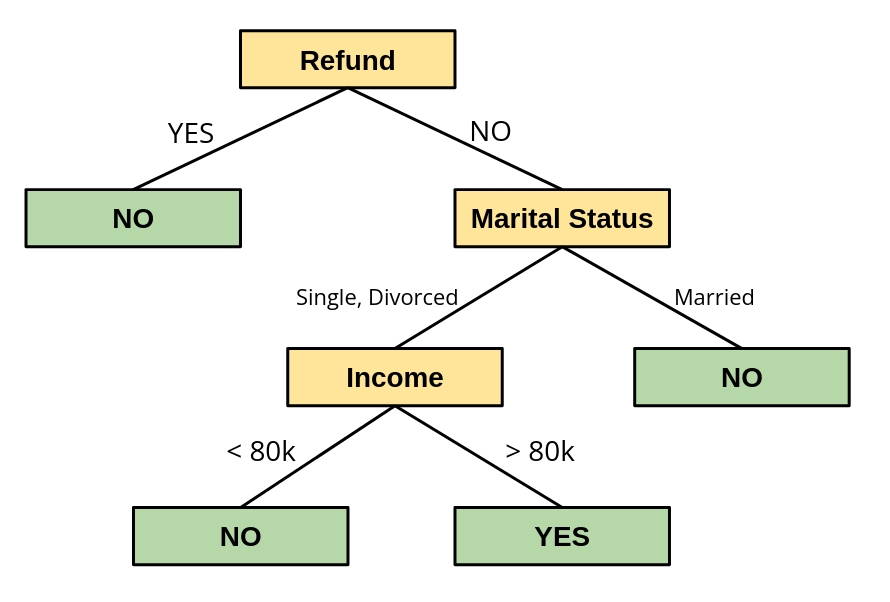

In [1]:
from IPython.display import Image
Image(filename="tree.jpg", width=500, height=300)

Using the above Decision Tree, what class would you predict for the following unseen record:

| Refund | Marital Status | Income |
|--------|----------------|--------|
| No     | Married        | 90k    |

No

Working with a dataset that attempts to understand the relationship between `heart disease` and whether or not a person experiences `chest_pain` and/or has `thalassemia`. All the attributes are binary (either 0 or 1) for simplicity. 

In [2]:
import numpy as np

data = np.genfromtxt(fname='./dataset.tsv', delimiter = '\t', names = True)

a) Before splitting the dataset at all, we observe the following distribution of 1s and 0s in the `heart_disease` class:

In [3]:
print(data["heart_disease"])

[1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 1. 1. 1.]


write a function that calculates the GINI of that node.

The further away from 0.5 the gini is, the better. <br>
Or the lower the gini, the better.

In [4]:
def gini(node):
    yes = sum(node) / len(node)
    frequencies = [
        yes,
        1 - yes
    ]
    return 1 - sum([f**2 for f in frequencies])

print("GINI of the node is ", gini(data["heart_disease"]))

GINI of the node is  0.48979591836734704


b) Write a function that computes the gini of a split.

In [5]:
def gini_split(data, attr, target_name):
    gini_sum = 0
    for value in set(data[attr]):
        mask = data[attr] == value
        gini_sum += gini(data[target_name][mask]) * sum(mask) / len(data[attr])
    return gini_sum

print("GINI of split on thalassemia = ", gini_split(data, "thalassemia", "heart_disease"))
print("GINI of split on chest_pain = ", gini_split(data, "chest_pain", "heart_disease"))

GINI of split on thalassemia =  0.23469387755102047
GINI of split on chest_pain =  0.4419642857142857


But it is easy to construct a tree that is too complex and overfits the data.

Solutions:
* Early termination (stop before tree is fully grown - use majority vote at leaf node)
    * Stop at some specified depth
    * Stop if size of node is below some threshold
    * Stop if gini does not improve
* Pruning (create fully grown tree then trim)

We can represent a decision tree recursively with the `Node` class below.

In [6]:
class Node:
    def __init__(self, attribute):
        self.attr = attribute
        self.left = None
        self.right = None
        self.vote = None
    
    def _node_at(self, depth):
        pretty_print = ""
        if self.left is not None:
            for _ in range(depth):
                pretty_print += "| "
            pretty_print += self.attr + ' = 0: \n'
            pretty_print += self.left._node_at(depth + 1)
    
        if self.right is not None:
            for _ in range(depth):
                pretty_print += "| "
            pretty_print += self.attr + ' = 1: \n'
            pretty_print += self.right._node_at(depth + 1)
        
        if self.right is None and self.left is None:
            for _ in range(depth):
                pretty_print += "| "
            pretty_print += "vote = " + str(self.vote) + '\n'
        
        return pretty_print

    def __repr__(self):
        return self._node_at(0)
    
B = Node("B")
C = Node("C")
left_leaf = Node("leaf")
left_leaf.vote = 0
right_leaf = Node("leaf")
right_leaf.vote = 1

B.right = right_leaf
B.left = left_leaf
C.right = right_leaf
C.left = left_leaf

tree = Node("A")
tree.left = B
tree.right = C

print(tree)

A = 0: 
| B = 0: 
| | vote = 0
| B = 1: 
| | vote = 1
A = 1: 
| C = 0: 
| | vote = 0
| C = 1: 
| | vote = 1



Each node is defined by splitting the dataset on a specific attribute. If the attribute value is 0, we explore the left node, if the attribute value is 1, we explore the right node. The left and right nodes are both of type `Node`. If the node has no left node and no right node then it is a leaf node and should contain a vote for what class should be predicted.

c) Write a function that takes in a decision tree and a data point, and walks through the tree based on the data point's attribute values to predict its class.

In [7]:
def predict(tree : Node, example):
    if tree.left is None and tree.right is None:
        return tree.vote
    
    if example[tree.attr] == 0:
        return predict(tree.left, example)

    if example[tree.attr] == 1:
        return predict(tree.right, example)

    return 0

print(predict(tree, {"A": 0, "B": 1, "C": 0})) # A -> B -> right
print(predict(tree, {"A": 0, "B": 0, "C": 0})) # A -> B -> left
print(predict(tree, {"A": 1, "B": 1, "C": 0})) # A -> C -> left
print(predict(tree, {"A": 1, "B": 1, "C": 1})) # A -> C -> right


1
0
0
1


d) Write a function that finds the best attribute to split on wrt the GINI of the split. Recall a smaller GINI is better.

In [8]:
def get_best_attribute(data, target_name):
    best_attr = None
    for attr in data.dtype.names:
        if attr != target_name:
            if best_attr is None:
                best_attr = attr
            elif gini_split(data, attr, target_name) < gini_split(data, best_attr, target_name):
                best_attr = attr
    return best_attr

e) Complete the code below to build a `SimpleDecisionTree` on the dataset provided.

In [9]:
class SimpleDecisionTree:
    
    def __init__(self, max_depth, data, target_name):
        self.max_depth = max_depth
        self.data = data
        self.target_name = target_name
        self.tree = None
        self.default_class = None


    def __repr__(self):
        return self.tree.__repr__()

    def get_subset(self, data, attr):
        subset_1 = data[data[attr] == 0]
        subset_2 = data[data[attr] == 1]
        return subset_1, subset_2

    def gini_split(self, data, attr):
        gini_sum = 0
        for value in set(data[attr]):
            mask = data[attr] == value
            gini_sum += gini(data[self.target_name][mask]) * sum(mask) / len(data[attr])
        return gini_sum

    def get_majority_vote(self, data):
        return np.argmax(np.bincount(data[self.target_name].astype(int)))

    def get_best_attribute(self, data):        
        best_attr = None
        for attr in data.dtype.names:
            if attr != self.target_name:
                if best_attr is None:
                    best_attr = attr
                elif self.gini_split(data, attr) < self.gini_split(data, best_attr):
                    best_attr = attr
        return best_attr


    def build_tree(self, data, depth):        
        attr = self.get_best_attribute(data)
        node = Node(attr)

        if depth == 0:
            if data is None:
                node.vote = self.default_class
            else:
                node.vote = self.get_majority_vote(data)
            return node

        left, right = self.get_subset(data, node.attr)

        node.left = self.build_tree(left, depth - 1)
        node.right = self.build_tree(right, depth - 1)

        if node.left is None and node.right is None:
            node.vote = self.get_majority_vote(data)
            
        return node


    def train(self):
        if self.max_depth > len(self.data.dtype.names) - 1:
            self.max_depth = len(self.data.dtype.names) - 1

        self.default_class = self.get_majority_vote(self.data)
        self.tree = self.build_tree(self.data, self.max_depth)


simple_tree = SimpleDecisionTree(2, data, "heart_disease")
simple_tree.train()
print(simple_tree)

thalassemia = 0: 
| chest_pain = 0: 
| | vote = 0
| chest_pain = 1: 
| | vote = 0
thalassemia = 1: 
| chest_pain = 0: 
| | vote = 1
| chest_pain = 1: 
| | vote = 1

